# The Purpose of this notebook is to a quick evaluation of embeddings in a SIF model to see how well they predict a few examples of n2c2 data

In [1]:
import os
import sys

import pickle

import pandas as pd

import numpy as np

import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn.metrics import pairwise_distances

import gensim
from gensim.models import KeyedVectors
print('gensim version : {}'.format(gensim.__version__))

import spacy
print('Spacy version : {}'.format(spacy.__version__))

c:\anaconda3\envs\n2c2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
c:\anaconda3\envs\n2c2\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
c:\anaconda3\envs\n2c2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


gensim version : 3.4.0
Spacy version : 2.0.18


In [2]:
sys.path.append('../src')
import data_io, params, SIF_embedding
from SIF_embedding import get_weighted_average

In [3]:
from data_io_w2v import load_w2v_word_map

In [4]:
# input
#wordfile = '../data/glove.840B.300d.txt' # word vector file, can be downloaded from GloVe website
wordfile = r'C:/temp_embeddings/pubmed+wiki+pitts-nopunct-lower-cbow-n10.bin'

#EMBEDDINGS_FORMAT = 'GLOVE'
EMBEDDINGS_FORMAT = 'WORD2VEC_BIN'

LOWERCASE_TOKENS = True

weightfile = '../auxiliary_data/enwiki_vocab_min200.txt' # each line is a word and its frequency

weightpara = 1e-3 # the parameter in the SIF weighting scheme, usually in the range [3e-5, 3e-3]
rmpc = 1 # number of principal components to remove in SIF weighting scheme
sentences = ['this is an example sentence', 'this is another sentence that is slightly longer']

In [5]:
%%time

# load word vectors
#(words, We) = data_io.getWordmap(wordfile)

words = None
We = None
if EMBEDDINGS_FORMAT == 'GLOVE':
    print('Loading embeddings as GLOVE')
    (words, We) = data_io.load_glove_word_map(wordfile)
elif EMBEDDINGS_FORMAT == 'WORD2VEC_BIN':
    (words, We) = load_w2v_word_map(wordfile, binary = True)
elif EMBEDDINGS_FORMAT == 'WORD2VEC_TXT':
    (words, We) = load_w2v_word_map(wordfile, binary = False)

Loading word2vec formatted embeddings from [C:/temp_embeddings/pubmed+wiki+pitts-nopunct-lower-cbow-n10.bin] with binary=True
Wall time: 22.1 s


In [6]:
# load word weights
word2weight = data_io.getWordWeight(weightfile, weightpara) # word2weight['str'] is the weight for the word 'str'
weight4ind = data_io.getWeight(words, word2weight) # weight4ind[i] is the weight for the i-th word

In [7]:
# set parameters
sif_params = params.params()
sif_params.rmpc = rmpc

In [8]:
class SIFModel(object):
    def __init__(self):
        self.trained = False
        self.svd = None
        self.word_map = None
        self.params = params
        
    def save(self, filename):
        components = [self.word_map, self.weight4ind, self.params, self.svd]
        joblib.dump(components, filename)
        
    def load(self, filename):
        components = joblib.load(filename)
        self.trained = True
        self.word_map = components[0]
        self.weight4ind = components[1]
        self.params = components[2]
        self.svd = components[3]

    def transform(self, We, sentences):
        x, m = data_io.sentences2idx(sentences, self.word_map) # x is the array of word indices, m is the binary mask indicating whether there is a word in that location
        w = data_io.seq2weight(x, m, self.weight4ind) # get word weights
        weighted_emb = get_weighted_average(We, x, w)
        # now use the model we've already loaded
        return self.remove_pc(weighted_emb)
        
    def compute_pc(self, X):
        # this is what happens in compute_pc() in src/SIF_embedding.py
        self.svd = TruncatedSVD(n_components=self.params.rmpc, n_iter=7, random_state=0)
        self.svd.fit(X)
        
    def remove_pc(self, X):
        pc = self.svd.components_
        
        if self.params.rmpc == 1:
            XX = X - X.dot(pc.transpose()) * pc
        else:
            XX = X - X.dot(pc.transpose()).dot(pc)
            
        return XX
        
    def fit(self, sentences, We, params, word_map, weight4ind):
        
        # store these off for pickling or extra transforms
        self.word_map = word_map
        self.weight4ind = weight4ind
        self.params = params
        
        x, m = data_io.sentences2idx(training_sentences, self.word_map) # x is the array of word indices, m is the binary mask indicating whether there is a word in that location
        w = data_io.seq2weight(x, m, self.weight4ind) # get word weights
        
        # now let's do some of what happens in src/SIF_embedding.py
        # but also keep some pieces along the way
        weighted_emb = get_weighted_average(We, x, w)
        
        self.compute_pc(weighted_emb)
        
        self.trained = True
        
        return self.remove_pc(weighted_emb)

In [9]:
# SIF filename
# TODO : Might need to change this to include the number of MIMIC documents used for training
SIF_JOBLIB_FILE_NAME = 'SIF_{0}_MIMIC_100.joblib'.format(os.path.splitext(os.path.basename(wordfile))[0])

print('Preparing to train a model to be stored at: {}'.format(SIF_JOBLIB_FILE_NAME))

Preparing to train a model to be stored at: SIF_pubmed+wiki+pitts-nopunct-lower-cbow-n10_MIMIC_100.joblib


In [10]:
loaded_sif_model = SIFModel()
loaded_sif_model.load(SIF_JOBLIB_FILE_NAME)

print('SIF model loaded...')

SIF model loaded...


In [18]:
example_sentences = [
    # 5
    "Albuterol [PROVENTIL/VENTOLIN] 90 mcg/Act HFA Aerosol 2 puffs by inhalation every 4 hours as needed.",
    "Albuterol [PROVENTIL/VENTOLIN] 90 mcg/Act HFA Aerosol 1-2 puffs by inhalation every 4 hours as needed #1 each.",

    # 4
    "Discussed goals, risks, alternatives, advanced directives, and the necessity of other members of the surgical team participating in the procedure with the patient.",
    "Discussed risks, goals, alternatives, advance directives, and the necessity of other members of the healthcare team participating in the procedure with the patient and his mother",
    

    # 3
    "Cardiovascular assessment findings include heart rate normal, Heart rhythm, atrial fibrillation with controlled ventricular response.",
    "Cardiovascular assessment findings include heart rate, bradycardic, Heart rhythm, first degree AV Block.",

    # 2
    "Discussed risks, goals, alternatives, advance directives, and the necessity of other members of the healthcare team participating in the procedure with (patient) (legal representative and others present during the discussion).",
    "We discussed the low likelihood that a blood transfusion would be required during the postoperative period and the necessity of other members of the surgical team participating in the procedure.",
    
    # 1
    "No: typical 'cold' symptoms; fever present (greater than or equal to 100.4 F or 38 C) or suspected fever; rash; white patches on lips, tongue or mouth (other than throat); blisters in the mouth; swollen or 'bull' neck; hoarseness or lost voice or ear pain",
    "New wheezing or chest tightness, runny or blocked nose, or discharge down the back of the throat, hoarseness or lost voice.",
    
    # 0
    "The risks and benefits of the procedure were discussed, and the patient consented to this procedure.",
    "The content of this note has been reproduced, signed by an authorized physician in the space above, and mailed to the patient's parents, the patient's home care company."
]

if LOWERCASE_TOKENS = True:
    for i in range(len(example_sentences)):
        example_sentences[i] = example_sentences[i].lower()

SyntaxError: invalid syntax (<ipython-input-18-ab282919c082>, line 28)

In [ ]:
embeddings = loaded_sif_model.transform(We, example_sentences)

In [ ]:
def plot_similarity(labels, features, rotation):
  #corr = np.inner(features, features)
  corr = features
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr*5,
      xticklabels=[label[:20] for label in labels],
      yticklabels=[label[:20] for label in labels],
      vmin=0,
      vmax=5,
      cmap="YlOrRd",
      annot=True)
  g.set_xticklabels([label[:20] for label in labels], rotation=rotation)
  g.set_title("Semantic Textual Similarity")

In [ ]:
cosine_distances = pairwise_distances(embeddings, metric='cosine')

In [19]:
cosine_similarity = 1.0 - cosine_distances

In [20]:
print(cosine_similarity)

[[ 1.          0.97714261 -0.20157387 -0.16424356 -0.09485491 -0.18215428
  -0.08659384 -0.14764425 -0.02033581  0.09352898 -0.16578681  0.0303608 ]
 [ 0.97714261  1.         -0.12345239 -0.08047377 -0.10153267 -0.19339089
  -0.00264245 -0.04625375 -0.05389073  0.0837525  -0.07283308  0.08302014]
 [-0.20157387 -0.12345239  1.          0.79928797  0.14324345  0.23388289
   0.85455086  0.76553973 -0.23010395 -0.2937411   0.62186199  0.37004563]
 [-0.16424356 -0.08047377  0.79928797  1.          0.01040292  0.11804562
   0.89427288  0.65686992 -0.20996227 -0.13202034  0.65938657  0.52579441]
 [-0.09485491 -0.10153267  0.14324345  0.01040292  1.          0.84176858
   0.0533816   0.17023366 -0.285808   -0.2422152   0.15976527 -0.14500048]
 [-0.18215428 -0.19339089  0.23388289  0.11804562  0.84176858  1.
   0.1380018   0.18195833 -0.2208962  -0.27861474  0.15374508 -0.02763706]
 [-0.08659384 -0.00264245  0.85455086  0.89427288  0.0533816   0.1380018
   1.          0.71388947 -0.15601992 -0.

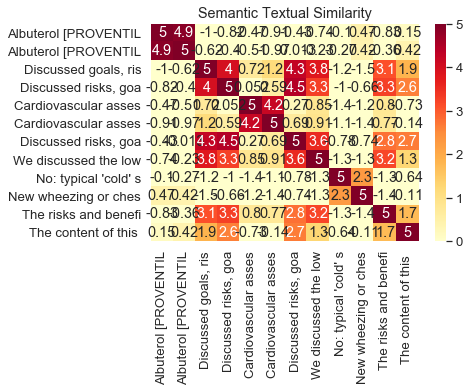

In [21]:
plot_similarity(example_sentences, cosine_similarity, 90)